# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.


# Laboratory 2 - PyTorch, Convolution and Correlation, Filtering, Simple Neural Networks

The goal of the Laboratory 2 is to:
<ul>
  <li> Familiarize yourself with basic PyTorch functionalities.
  <li> Understand and implement 2-D correlation / convolution functions.
  <li> Undersand the differences between CPU and GPU execution.
  <li> Learn how to implement simple neural network architectures in PyTorch.
</ul>

For simplicity, during this laboratory we are not going to use any medical dataset.

### Part I - Convolution and Correlation

The first task is to understand the convolution and correlation operators.

Let's start from defining 2-D arrays and apply the built-in convolution/correlation function available in SciPy for NumPy arrays:

In [1]:
import numpy as np
import scipy.ndimage as nd

input = np.array([
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [3, 4, 5, 4, 3],
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2]
])

filter = np.array([
    [0, 1, 0],
    [-1, 0, 1],
    [0, -1, 0]
])

convolution_result = nd.convolve(input, filter, mode="constant")
correlation_result = nd.correlate(input, filter, mode="constant")

print("Convolution result: ")
print(convolution_result)
print("Correlation result: ")
print(correlation_result)


Convolution result: 
[[ 3  2  1  0  5]
 [-2  4  4  2  0]
 [-8 -5 -2  1  4]
 [-2 -2 -3 -2  0]
 [-3 -1 -1 -1  1]]
Correlation result: 
[[-3 -2 -1  0 -5]
 [ 2 -4 -4 -2  0]
 [ 8  5  2 -1 -4]
 [ 2  2  3  2  0]
 [ 3  1  1  1 -1]]


Analyze the obtained results and:
<ul>
  <li> Answer the question - What is the difference between correlation and convolution (for real numbers)?
  <li> Can you calculate the output on paper, directly using the definition of 2-D convolution/correlation operator with zero-padding at input boundaries?
</ul>

#**MY ANSWER**


Now let's do the same with the PyTorch library. PyTorch is a library dedicated to deep learning implemented on top of CUDA. In short - it allows to efficiently prototype and train neural networks using multiple GPUs.

In [3]:
import torch as tc
import torch.nn as nn

input = tc.Tensor([
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [3, 4, 5, 4, 3],
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2]
]).type(tc.float32)

filter = tc.Tensor([
    [0, 1, 0],
    [-1, 0, 1],
    [0, -1, 0]
]).type(tc.float32)

print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")
input = input.unsqueeze(0).unsqueeze(0) # PyTorch assumes dimension: BxCxYxX (to be discussed later)
filter = filter.unsqueeze(0).unsqueeze(0)  # PyTorch assumes dimension: BxCxYxX (to be discussed later)
print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")

convolution_result = tc.nn.functional.conv2d(input, filter, padding=1)
print("Convolution result: ")
print(convolution_result)

Input size: torch.Size([5, 5])
Filter sie: torch.Size([3, 3])
Input size: torch.Size([1, 1, 5, 5])
Filter sie: torch.Size([1, 1, 3, 3])
Convolution result: 
tensor([[[[-3., -2., -1.,  0., -5.],
          [ 2., -4., -4., -2.,  0.],
          [ 8.,  5.,  2., -1., -4.],
          [ 2.,  2.,  3.,  2.,  0.],
          [ 3.,  1.,  1.,  1., -1.]]]])


As you may observe - the results is the same as the output of correlation (not convolution). This is indeed a problem with PyTorch (and other DL libraries) nomenclature. The convolution operators in these libaries implement the correlation operator.

The next task is to implement your own 2-D correlation function using PyTroch (without using the built-in functions for correlation/convolution):

In [4]:
"""
def our_2d_correlation(input, filter, padding=1):
  result = tc.zeros_like(input)

  assert filter.size(2) % 2 == 1 and filter.size(3) % 2 == 1, "Filter size must be odd" # Ensure filter size is odd
  input_height, input_width = input.size(2), input.size(3) # Get input size
  filter_height, filter_width = filter.size(2), filter.size(3) # Get filter size
  padded_input = nn.functional.pad(input, (padding, padding, padding, padding), mode='constant', value=0) # Apply padding
  result = tc.zeros_like(input) # Initialize result tensor

  for i in range(input_height):
        for j in range(input_width):

          input_patch = padded_input[:, :, i:i + filter_height, j:j + filter_width] # Extract the region of interest from the padded input
          correlation = tc.sum(input_patch * filter, dim=(2, 3), keepdim=True) # Perform element-wise multiplication and summation

          result[:, :, i, j] = correlation.squeeze()

  # TODO - implement the 2-D correlation with the same funcionality as PyTorch conv2D function (without bias, stride and groups, but with padding).
  return result
"""

def our_2d_correlation(input, filter, padding=1):
  [dim1, dim2, x_max, y_max] = input.shape
  #result = tc.zeros_like(input) # asi: tried to create an empty matrix capable of holding the output
  result = tc.full((dim1,dim2,x_max+2*padding-2,y_max+2*padding-2),0)
  padded_input = tc.full((dim1,dim2,x_max+2*padding,y_max+2*padding),0)
  padded_input[0,0, padding:x_max+padding, padding:y_max+padding] = input


  for i in range(0,x_max+2*padding-2):
    for j in range(0,y_max+2*padding-2):

      a = padded_input[0,0,i : i+3,j : j+3]
      outcome = tc.sum(a*filter)
      result[:,:,i,j] = outcome

  return result

our_2d_correlation(input,filter,2)

tensor([[[[ 0, -1, -2, -3, -4, -5,  0],
          [ 1, -3, -2, -1,  0, -5, -5],
          [ 5,  2, -4, -4, -2,  0, -1],
          [ 3,  8,  5,  2, -1, -4, -3],
          [ 1,  2,  2,  3,  2,  0, -1],
          [ 2,  3,  1,  1,  1, -1, -2],
          [ 0,  2,  2,  2,  2,  2,  0]]]])

And now compare the results with the library function:

In [32]:
import torch as tc

input = tc.Tensor([
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [3, 4, 5, 4, 3],
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2]
]).type(tc.float32)

filter = tc.Tensor([
    [0, 1, 0],
    [-1, 0, 1],
    [0, -1, 0]
]).type(tc.float32)



print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")
input = input.unsqueeze(0).unsqueeze(0) # PyTorch assumes dimension: BxCxYxX (to be discussed later)
filter = filter.unsqueeze(0).unsqueeze(0)  # PyTorch assumes dimension: BxCxYxX (to be discussed later)
print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")

print("Padding: 1")
pytorch_convolution_result = tc.nn.functional.conv2d(input, filter, padding=1)
our_convolution_result = our_2d_correlation(input, filter, padding=1)
print("PyTorch Convolution result: ")
print(pytorch_convolution_result)
print("Our Convolution result: ")
print(our_convolution_result)
print(f"Difference: {tc.sum(pytorch_convolution_result - our_convolution_result)}")

print("Padding: 2")
pytorch_convolution_result = tc.nn.functional.conv2d(input, filter, padding=2)
our_convolution_result = our_2d_correlation(input, filter, padding=2)
print("PyTorch Convolution result: ")
print(pytorch_convolution_result)
print("Our Convolution result: ")
print(our_convolution_result)
print(f"Difference: {tc.sum(pytorch_convolution_result - our_convolution_result)}")

print("Padding: 3")
pytorch_convolution_result = tc.nn.functional.conv2d(input, filter, padding=2)
our_convolution_result = our_2d_correlation(input, filter, padding=2)
print("PyTorch Convolution result: ")
print(pytorch_convolution_result)
print("Our Convolution result: ")
print(our_convolution_result)
print(f"Difference: {tc.sum(pytorch_convolution_result - our_convolution_result)}")

Input size: torch.Size([5, 5])
Filter sie: torch.Size([3, 3])
Input size: torch.Size([1, 1, 5, 5])
Filter sie: torch.Size([1, 1, 3, 3])
Padding: 1
PyTorch Convolution result: 
tensor([[[[-3., -2., -1.,  0., -5.],
          [ 2., -4., -4., -2.,  0.],
          [ 8.,  5.,  2., -1., -4.],
          [ 2.,  2.,  3.,  2.,  0.],
          [ 3.,  1.,  1.,  1., -1.]]]])
Our Convolution result: 
tensor([[[[-3., -2., -1.,  0., -5.],
          [ 2., -4., -4., -2.,  0.],
          [ 8.,  5.,  2., -1., -4.],
          [ 2.,  2.,  3.,  2.,  0.],
          [ 3.,  1.,  1.,  1., -1.]]]])
Difference: 0.0
Padding: 2
PyTorch Convolution result: 
tensor([[[[ 0., -1., -2., -3., -4., -5.,  0.],
          [ 1., -3., -2., -1.,  0., -5., -5.],
          [ 5.,  2., -4., -4., -2.,  0., -1.],
          [ 3.,  8.,  5.,  2., -1., -4., -3.],
          [ 1.,  2.,  2.,  3.,  2.,  0., -1.],
          [ 2.,  3.,  1.,  1.,  1., -1., -2.],
          [ 0.,  2.,  2.,  2.,  2.,  2.,  0.]]]])
Our Convolution result: 
tensor([[[

RuntimeError: The size of tensor a (7) must match the size of tensor b (5) at non-singleton dimension 3

After completing the exercise you should have much better understanding of the convolution and the basics of PyTorch.

### Part II - Filtering

You are now familiar with the convolution/correlation operators. Let's use this knowledge to calculate the gradient from Laboratory 1 - however, this time using the PyTorch convolution (correlation) operator.

Let's start with loading the image and calculating the gradient using NumPy (the same as in the Laboratory 1):

Image shape: (598, 282)
Image dtype: float32


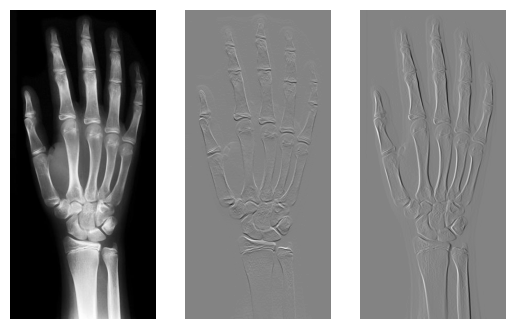

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("/content/xray.jpg")
array = np.array(image).astype(np.float32)
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) # Normalization to [0-1] range
array = normalize(array)
print(f"Image shape: {array.shape}")
print(f"Image dtype: {array.dtype}")

gradient_y_np, gradient_x_np = np.gradient(array)

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(array, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(gradient_y_np, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(gradient_x_np, cmap='gray')
plt.axis('off')
plt.show()

Now convert the NumPy array to PyTorch tensor and calculate the gradient using convolution (correlation operator).

Tensor shape: torch.Size([1, 1, 598, 282])


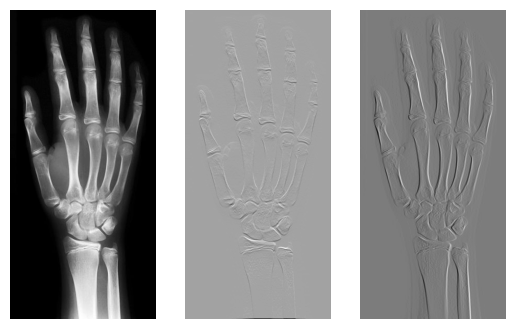

MSE Y: 0.0007901924545876682
MSE X: 0.011821948923170567


In [11]:
### TODO - convert the array to tensor with shape (1x1xYxX)

tensor = tc.from_numpy(array).unsqueeze(0).unsqueeze(0)
print(f"Tensor shape: {tensor.shape}")

### TODO - calculate the Y and X gradient using PyTorch convolution

filter_y = tc.Tensor([
    [0, -1, 0],
    [0, 0, 0],
    [0, 1, 0]
]).type(tc.float32)
filter_y = filter_y.unsqueeze(0).unsqueeze(0)

filter_x = tc.Tensor([
    [0, 0, 0],
    [1, 0, -1],
    [0, 0, 0]
]).type(tc.float32)
filter_x = filter_x.unsqueeze(0).unsqueeze(0)

gradient_x_tc = tc.nn.functional.conv2d(tensor,filter_x, padding=1)
gradient_y_tc = tc.nn.functional.conv2d(tensor, filter_y, padding=1)

### TODO - show the gradient calculated using PyTorch and calculate the difference between NumPy and PyTorch

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(array, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(gradient_y_tc[0, 0, :, :], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(gradient_x_tc[0, 0, :, :], cmap='gray')
plt.axis('off')
plt.show()

mse = lambda a, b: np.mean((a-b)**2)
print(f"MSE Y: {mse(gradient_y_np, gradient_y_tc[0, 0, :, :].numpy())}")
print(f"MSE X: {mse(gradient_x_np, gradient_x_tc[0, 0, :, :].numpy())}")

Can you describe what is the source of the difference between NumPy and PyTorch implementation? Think about that (hint: show difference images).

The filter used to calculate the gradient is an example of high-pass filter (filtering out low frequencies). Only high frequencies containing fast intensity changes are passed through.

The same operation can be performed for low-pass filters (e.g. uniform filter).

Define an uniform filter with size (5, 5) and filter the input image using PyTorch convolution operator. Visualize the output.

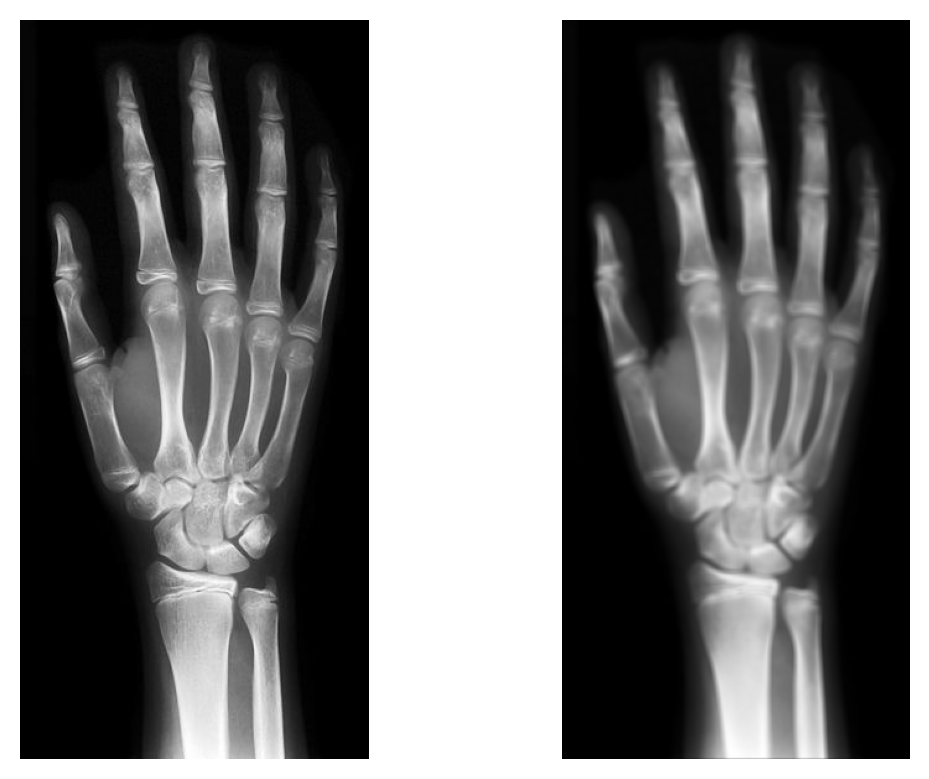

In [14]:
### TODO - perform uniform filtering (5, 5) of the input image using PyTorch convolution
filter = tc.ones((1,1,5,5))
divider = tc.sum(filter)
filter = (filter/divider)

smoothed_tensor = tc.nn.functional.conv2d(tensor,filter, padding=1) # TODO

plt.figure(dpi=200)
# plt.figure(dpi=100) # Tried a bit to change from 200 bc screen (as a trail)
plt.subplot(1, 2, 1)
plt.imshow(tensor[0, 0, :, :], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(smoothed_tensor[0, 0, :, :], cmap='gray')
plt.axis('off')
plt.show()

Important note: Uniform filter is not the best choice for low-pass filtering due to rather poor frequency response. Better idea is to use the Gaussian filter (will be discussed during the following laboratories).

### Part III - Execution Time

So far it may be not clear why using the PyTorch is useful. We can achieve the same convolution/correlation results directly using NumPy/SciPy.

Let's measure the execution time for convolving the input image with the uniform filter from the previous part:

In [15]:
import scipy.ndimage as nd
import time
### TODO - compare the execution time between SciPy and PyTorch

numpy_filter = np.ones((5,5))/25
print("--------------------------------")
t1 = time.time()
print("Timing NumPy: ")
%timeit convolution_numpy = nd.convolve(array, numpy_filter, mode="constant");
t2 = time.time()
print(t2-t1, "ms")
print("--------------------------------")
t3 = time.time()
print("Timing PyTorch: ")
%timeit convolution_pytorch = tc.nn.functional.conv2d(tensor,filter, padding=1);
t4 = time.time()
print(t4-t3, "ms")
print("--------------------------------")
print("Diffrence:")
print("PyTorch is faster times:",(t2-t1)/(t4-t3))

--------------------------------
Timing NumPy: 
5.5 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.431169033050537 ms
--------------------------------
Timing PyTorch: 
4.17 ms ± 680 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.428453207015991 ms
--------------------------------
Diffrence:
PyTorch is faster times: 1.2924688672963618


So far you can observe speed-up of a factor of (2-3). It is a result of using multiple CPU cores available in Google Colaboratory.

Now, let's transfer both the tensor and filter to GPU and repeat the experiment (it may require to change the execution enviroment withing Google Colaboratory):

In [16]:
### TODO - compare the execution time between SciPy and PyTorch using Google Colab GPU

tensor = tensor.to("cuda:0")
filter = filter.to("cuda:0")

print("--------------------------------")
t5 = time.time()
print("Timing NumPy: ")
%timeit convolution_numpy = nd.convolve(array, numpy_filter, mode="constant");
t6 = time.time()
print(t5-t6, "ms")
print("--------------------------------")
t7 = time.time()
print("Timing PyTorch: ")
%timeit convolution_pytorch = tc.nn.functional.conv2d(tensor,filter, padding=1);
t8 = time.time()
print(t7-t8, "ms")
print("--------------------------------")

--------------------------------
Timing NumPy: 
5.12 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
-4.41146445274353 ms
--------------------------------
Timing PyTorch: 
The slowest run took 8.79 times longer than the fastest. This could mean that an intermediate result is being cached.
35.4 µs ± 42.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-0.5895380973815918 ms
--------------------------------


Let's calculate the relative speedup from the run above:

In [17]:
speed_up = 5.45e-3 / 23.2e-6
print(f"Speed-up: {speed_up}")

Speed-up: 234.91379310344826


We accelerated the computation more than 200 hundred times by using the (relatively cheap) GPU available in Google Colaboratory. The speed-up may be even more significant when using high-end GPUs or TPUs dedicated directly to the convolution operation.

In [18]:
!nvidia-smi

Sat May 11 13:11:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              26W /  70W |    119MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
print("--------------------------------")
speed_up = (t4-t3) / (t5-t7)
print(f"NumPy: {speed_up}")
print("--------------------------------")
speed_up = (t2-t1) / (t7-t8)
print(f"Speed-up PyTorch: {speed_up}")

--------------------------------
NumPy: -0.7771256924091171
--------------------------------
Speed-up PyTorch: -7.51634042436169


### Part IV - Fully Connected Networks

The next part of the laboratory is dedicated to using PyTorch to implement simple fully connected (linear/affine) networks. They are probably the oldest neural networks and are used in various architectures (e.g. classification part of CNNs, transformer networks, recursive networks).

In this course we will use fully connected networks mainly as the classifier following the deep features calculation by the convolutional part of the network architecture.

Start with reading the following article:

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

And the documentation of the **Linear** layer available in PyTorch:

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In the following exercise you will use three modules: **Linear**, **ReLU** and **Sigmoid**. The **ReLU** and **Sigmoid** activation function will be motivated and discussed during the next lecture. For now - focus on the **Linear** layer.

Following the descriptions in the tutorial above, implement a fully connected neural network with the architecture as follows:

<ul>
  <li> Linear layer with input size: 128, and output size: 128
  <li> ReLU activation function
  <li> Linear layer with input size: 128 and output size: 64
  <li> ReLU activation function
  <li> Linear layer with input size: 64 and output size: 2
  <li> Sigmoid activation function
</ul>

In [24]:
class SimpleNeuralNetwork(tc.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = tc.nn.Sequential(
            tc.nn.Linear(128, 128),
            tc.nn.ReLU(),
            tc.nn.Linear(128, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 2),
        )
    def forward(self, x):
      logits = self.linear_relu_stack(x)
      return logits

Now generate a random input and provide it as the input to the implemented neural network. Then, print the summary of the implemented architecture.

In [25]:
from torchsummary import summary

#NameError: name 'device' is not defined
device = "cuda" if tc.cuda.is_available() else "cpu"
network = SimpleNeuralNetwork()

random_input = tc.randn((4, 128))
random_output = network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
summary(network.to(device), (4, 128))

Size of the random input: torch.Size([4, 128])
Size of the random output: torch.Size([4, 2])
Random output: 
tensor([[-0.1654,  0.0591],
        [-0.0034,  0.0591],
        [-0.1770,  0.0506],
        [-0.2211, -0.0289]], grad_fn=<AddmmBackward0>)
Network summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 4, 128]          16,512
              ReLU-2               [-1, 4, 128]               0
            Linear-3                [-1, 4, 64]           8,256
              ReLU-4                [-1, 4, 64]               0
            Linear-5                 [-1, 4, 2]             130
Total params: 24,898
Trainable params: 24,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.09
Estimated Total Size (MB): 0.11
-----------------------------------

The generated input is random. This is acutally expected. First, we generate just a random input, second, the neural network has not been trained yet. We will discuss the neural networks training process during Laboratory 4.

One can wonder what does the "4" mean while generating the random input. The number represents the batch size. Batch size is the number of cases provided to the neural network at once. The batch size was introduced because usually it is impossible to input the whole dataset to the neural network in a single pass due to the memory limitations (will be discussed during Lecture 3 and Laboratory 4) and processing the dataset one-by-one cannot utilize fully the GPU parallelism (at least for 2-D images, for 3-D data sometimes just a single case can saturate the GPU memory). Therefore, it is useful to split the dataset into parts called batches.

### Part V - Convolutional Neural Networks

In the final part of this laboratory you are going to implement a simple convolutional neural network.

Please start from reading the documentation of:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

and

https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html

Then repeat the process from **Part IV** to implement the following architecture:

<ul>
  <li> Conv2D with:
    <ul>
      <li> Input channels: 3
      <li> Output channels: 32
      <li> Kernel size: 3
      <li> Stride : 1
      <li> Padding: 1
    </ul>
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 32
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 2
    </ul>
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 64
      <li> Output channels: 128
      <li> Kernel size: 3
      <li> Stride : 1
      <li> Padding: 1
    </ul>
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 128
      <li> Output channels: 128
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 2
    </ul>
  <li> ReLU activation function
  <li> Adaptive Average Pooling to size (B, 128, 1, 1)
</ul>

In [26]:
class SimpleConvolutionalNeuralNetwork(tc.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = tc.nn.Sequential(
            tc.nn.Conv2d(3, 32, 3, stride=1, padding=1),
            tc.nn.ReLU(),
            tc.nn.Conv2d(32, 64, 3, stride=2, padding=2),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 128, 3, stride=1, padding=1),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 128, 3, stride=2, padding=2),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1, 1)),
            )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


Now generate a random input and provide it as the input to the implemented neural network. Then, print the summary of the implemented architecture.

In [27]:
convolutional_network = SimpleConvolutionalNeuralNetwork()

random_input = tc.randn((4, 3, 224, 224))
random_output = convolutional_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
summary(convolutional_network.to(device), (3, 224, 224))

Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 128, 1, 1])
Random output: 
tensor([[[[1.8154e-02]],

         [[1.2150e-04]],

         [[2.2766e-03]],

         [[6.1967e-04]],

         [[5.3476e-03]],

         [[1.3706e-03]],

         [[1.7819e-02]],

         [[1.5958e-02]],

         [[2.4347e-02]],

         [[4.4871e-02]],

         [[5.8474e-03]],

         [[5.9930e-02]],

         [[7.2736e-04]],

         [[4.1863e-02]],

         [[7.1907e-05]],

         [[4.6692e-02]],

         [[4.5502e-02]],

         [[1.2393e-03]],

         [[1.0254e-02]],

         [[4.9272e-02]],

         [[3.3829e-03]],

         [[5.5593e-03]],

         [[2.5728e-06]],

         [[2.5588e-02]],

         [[1.1708e-03]],

         [[2.2166e-02]],

         [[5.1349e-03]],

         [[2.1081e-04]],

         [[2.6691e-05]],

         [[1.1515e-02]],

         [[5.5835e-03]],

         [[2.5521e-02]],

         [[2.1600e-02]],

         [[7.7362

Finally let's compose the network from **Part IV** to the just implemented CNN architecture:

In [30]:
#TODO DONE

class ClassificationNeuralNetwork(tc.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_net = SimpleConvolutionalNeuralNetwork()
        self.fc_net = SimpleNeuralNetwork()


    def forward(self, x):
        features = self.conv_net(x)
        features = tc.flatten(features, 1)
        logits = self.fc_net(features)
        return logits

And test it on a randomly generated 2-D image:

In [31]:
# NOTHING TO CHANGE

classification_network = ClassificationNeuralNetwork()

random_input = tc.randn((4, 3, 224, 224))
random_output = classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
summary(classification_network.to(device), (3, 224, 224))

Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 2])
Random output: 
tensor([[ 0.0561, -0.1102],
        [ 0.0562, -0.1102],
        [ 0.0561, -0.1102],
        [ 0.0561, -0.1102]], grad_fn=<AddmmBackward0>)
Network summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
            Conv2d-3         [-1, 64, 113, 113]          18,496
              ReLU-4         [-1, 64, 113, 113]               0
            Conv2d-5        [-1, 128, 113, 113]          73,856
              ReLU-6        [-1, 128, 113, 113]               0
            Conv2d-7          [-1, 128, 58, 58]         147,584
              ReLU-8          [-1, 128, 58, 58]               0
 AdaptiveAvgPool2d-9            [-1, 128, 1, 1]               0
SimpleConvolutionalNe

Congratulations, you have just implemented a basic CNN dedicated to the binary classification of 2-D RGB images. The network is not trained yet. The neural network training will be discussed during Laboratory 4.

## Conclusion

This is the end of Laboratory 2. You should be now familiar with:
<ol>
  <li> How to use the PyTorch library.
  <li> How to implement convolution and correlation operators.
  <li> How to apply low-pass and high-pass filters.
  <li> The differences between CPU/GPU execution.
  <li> Implementing basic neural networks with PyTorch.
</ol>

The next lecture / laboratory will discuss the PyTorch dataloaders. We are going to implement several dataloaders dedicated to loading medical datasets.